# Variational optimization of QHO

In [1]:
# front matter
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.special import hermite
from math import factorial
from scipy.optimize import minimize


# If your screen has retina display this will increase resolution of plots
%config InlineBackend.figure_format = 'retina' 

In [2]:
# Basic constants
# grids
N=2000 

# spatial grid
XMin=-50
XMax=50
X=np.linspace(XMin, XMax, N)

# momentum grid
P=(2*np.pi/(XMax-XMin))*np.concatenate((np.arange(N//2), np.arange(-N//2,0))) 

w1=1 
w0=0.35

# states involved in the simulation
n=16

# beta range
tau=2
dt=0.1
M=int(tau/dt)
beta = 6
t_list = np.linspace(0, tau, M)

## Function Defination

In [3]:
# Eigenfunction
def psi(w,v):
    Hr=hermite(v)
    if w==0:
        Psix = 1./np.sqrt(np.sqrt(np.pi/w0)*2**v*factorial(v))*Hr(np.sqrt(w0)*X)*np.exp(-0.5*w0*X**2)
    elif w==1:
        Psix = 1./np.sqrt(np.sqrt(np.pi/w1)*2**v*factorial(v))*Hr(np.sqrt(w1)*X)*np.exp(-0.5*w1*X**2)
    normal = np.sqrt(sum(abs(Psix)**2)) # normalization
    return Psix/normal

# Eigenvalue    
def E(w,v):
    return w0*(v+0.5) if w==0 else w1*(v+0.5)

# Partition function
def Z(w):
    return sum([np.exp(-beta * E(w,v)) for v in range(n)])


In [4]:
# Time operator
def simulation(v,wp):
    psi_0 = psi(0, v)
    for m in range(M):
        UV = np.exp(-1j*((wp[m]*X)**2/2)*dt/2)
        UT = np.exp(-1j*(P**2/2)*dt)  
        psi_1 = UV*psi_0
        phi_2 = np.fft.fft(psi_1)   # wavefunction in momentum space
        phi_3 = UT*phi_2
        psi_3 = np.fft.ifft(phi_3)
        psi_4 = UV*psi_3
        psi_0 = psi_4  # prepare a new cycle
    return psi_0

In [5]:
# Variance
def var(wp):
    Z0= Z(0)
    DF= 1/beta*math.log(Z(0)/Z(1))
    Fm=0.0
    Sm=0.0
    for i in range(n):
        for j in range(n):
            psit=simulation(i,wp)
            psi1=psi(1,j)
            abs_dot= abs(np.dot(psi1,psit))**2
            Fm+=np.exp(-beta*E(1,j))*abs_dot/Z0
            Sm+=np.exp(-beta*(2*E(1,j)-E(0,i)))*abs_dot/Z0
    Var=Sm-Fm**2
    Var_dis=Var/np.exp(-2*beta*DF)
    return Var_dis

## N-dimensional polynomial work protocal
$\omega(t) = \omega_0 + a_1 t + a_2 t^2 + \cdots + a_{n-1} t^{n-1} + a_n t^n$

In [6]:
# N-dimensional polynomial work protocal
# power_t vector (t_j^0, t_j^1, ..., t_j^(n-1))
def power_vector(n):
    return np.array([[t_list[j]**i for i in range(n)] for j in range(M)])
# work protocal
def wp_poly(a_list):
    n = len(a_list)+2
    q=np.sum(power_vector(n-2)[M-1]*a_list)
    a1=(w1-w0)/tau-q*tau
    a_list = np.append([w0, a1],a_list)
    k = [round(np.sum(power_vector(n)[i]*a_list), 8) for i in range(M)]
    return k

### Constrained optimization

In [9]:
# Define target function
def poly_target_function(a_list):
    return var(wp_poly(a_list))

# Constraint function
def constraint_func(a_list):
    return wp_poly(a_list)

# Initial parameter value
# poly_initial_list = np.array(np.zeros(20))
# poly_initial_list = np.array(np.random.rand(8))
poly_initial_list = np.array([0.27749217,0.75387576,0.01323569,0.01359271,0.6826497,0.71385182,0.43347697,0.96091959] )


# Minimize the target function with the constraint
poly_optimization = minimize(poly_target_function, poly_initial_list, method='COBYLA', constraints={'type': 'ineq', 'fun': constraint_func})

# Output the optimized parameter and the m
# inimum value
poly_optimized_list = poly_optimization.x
poly_min_value = poly_optimization.fun

print("Converge :", poly_optimization.success)
print("Initial parameter list:", poly_initial_list)
print("Optimized parameter list:", poly_optimized_list)
print(wp_poly(poly_optimization.x))
print("Minimized Variance:", poly_min_value)

Converge : True
Initial parameter list: [0.27749217 0.75387576 0.01323569 0.01359271 0.6826497  0.71385182
 0.43347697 0.96091959]
Optimized parameter list: [ 0.27728275  0.75453352 -0.00161056 -0.14905972  0.64713038  0.3248799
 -0.16750486 -0.12324364]
[0.35, 1.47401943, 2.60946307, 3.76185638, 4.9378823, 6.14703503, 7.40375498, 8.72946763, 10.15356365, 11.71190072, 13.44088018, 15.36455288, 17.4715394, 19.67780912, 21.77055125, 23.32748873, 23.60503241, 21.38764869, 14.7897186, 1.0]
Minimized Variance: 2277800526.0072503


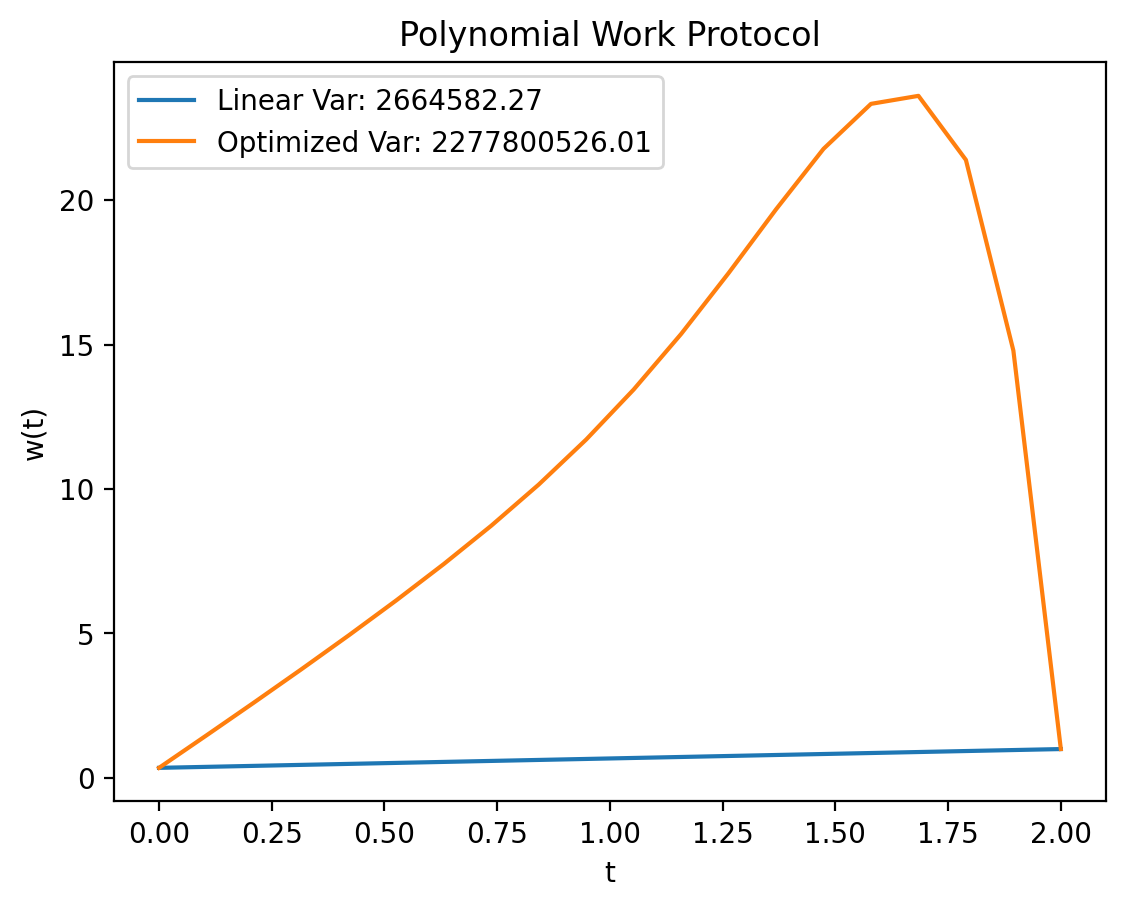

In [10]:
# Visualization
# x-axis
Poly_x_Var = t_list[M//2]

# initial work protocol guess
# plt.plot(t_list, wp_poly(poly_initial_list), label=f'Initial guessed Var: {var(wp_poly(poly_initial_list)):.2f}')
# poly_y_Var_initial = wp_poly(poly_initial_list)[M//2]

linear_list=np.array(np.zeros(20))
plt.plot(t_list, wp_poly(linear_list), label=f'Linear Var: {var(wp_poly(linear_list)):.2f}')
poly_y_Var_initial = wp_poly(linear_list)[M//2]


# optimized work protocol
plt.plot(t_list, wp_poly(poly_optimization.x),label=f'Optimized Var: {var(wp_poly(poly_optimization.x)):.2f}')
poly_y_Var_optimized = wp_poly(poly_optimization.x)[M//2]

plt.xlabel("t")
plt.ylabel("w(t)")
plt.title("Polynomial Work Protocol")
plt.legend()

plt.show()


### Result

Work protocal: [0.35, 0.35387089, 0.36908887, 0.4008702, 0.45557523, 0.54253862, 0.67661064, 0.88098802, 1.18958636, 1.64781994, 2.31020896, 3.23272882, 4.45725073, 5.98479837, 7.73366045, 9.47765518, 10.75903854, 10.76968468, 8.19324387, 1.0]


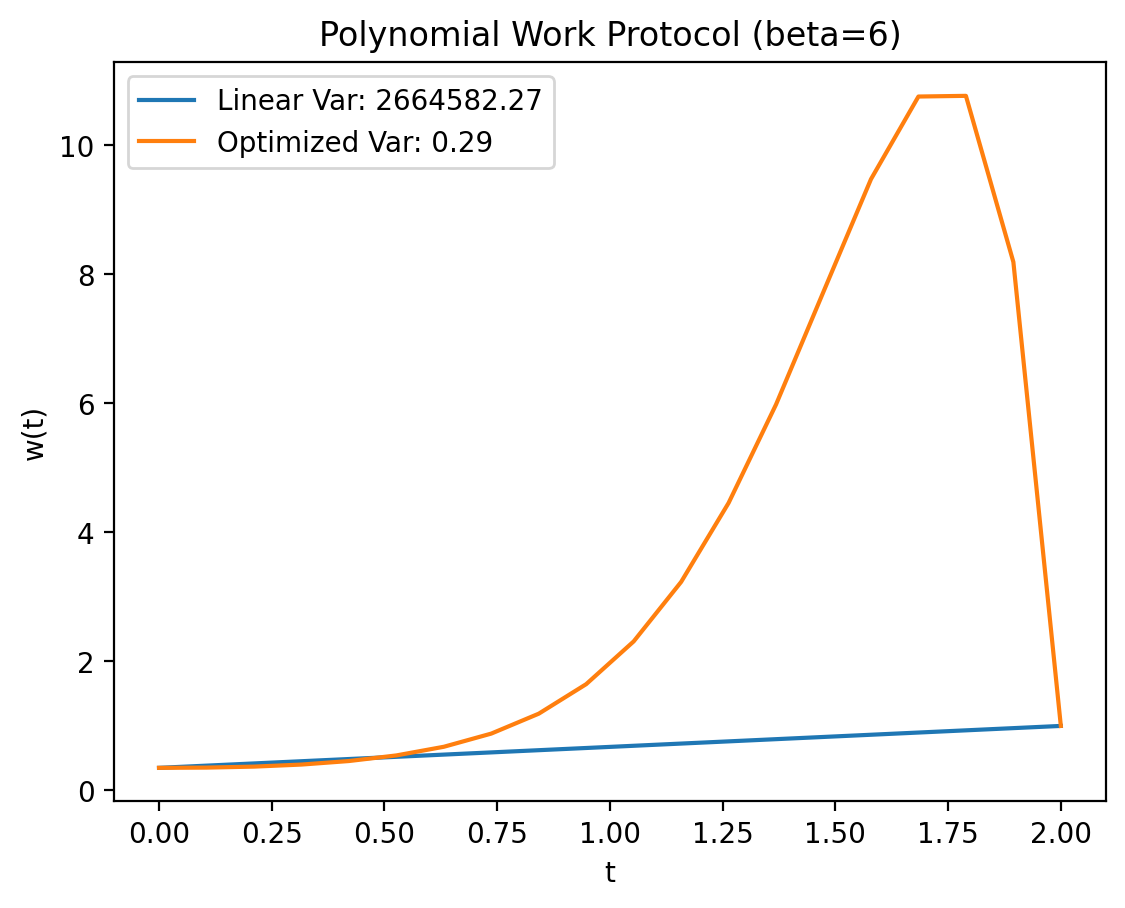

In [7]:
# Visualization
# x-axis
Poly_x_Var = t_list[M//2]

# initial work protocol guess
# plt.plot(t_list, wp_poly(poly_initial_list), label=f'Initial guessed Var: {var(wp_poly(poly_initial_list)):.2f}')
# poly_y_Var_initial = wp_poly(poly_initial_list)[M//2]

linear_list=np.array(np.zeros(20))
plt.plot(t_list, wp_poly(linear_list), label=f'Linear Var: {var(wp_poly(linear_list)):.2f}')
poly_y_Var_initial = wp_poly(linear_list)[M//2]

op_list=np.array([0.28497413,0.72532991,-0.02570182,-0.15657904,0.64912032,0.37199062,-0.14437167,-0.10364783])
# optimized work protocol
plt.plot(t_list, wp_poly(op_list),label=f'Optimized Var: {var(wp_poly(op_list)):.2f}')
poly_y_Var_optimized = wp_poly(op_list)[M//2]

print(f'Work protocal: {wp_poly(op_list)}')

plt.xlabel("t")
plt.ylabel("w(t)")
plt.title(f'Polynomial Work Protocol (beta={beta})')
plt.legend()

plt.show()
